# Prepare Cluster-by-Gene mC Profile

In [24]:
import pandas as pd
from ALLCools.mcds import MCDS
from ALLCools.clustering import cluster_enriched_features

In [2]:
mc_cluster = pd.read_csv(
    '/home/hanliu/cemba3c/projects/ALLCools/HIPBulk/DesideBulkLevel/snmC.anno.csv',
    header=None,
    index_col=0,
    squeeze=True)

m3c_cluster = pd.read_csv(
    '/home/hanliu/cemba3c/projects/ALLCools/HIPBulk/DesideBulkLevel/snm3C.anno.csv',
    header=None,
    index_col=0,
    squeeze=True)

mc_cluster = 'snmC_' + mc_cluster
m3c_cluster = 'snm3C_' + m3c_cluster
cell_cluster = pd.concat([mc_cluster, m3c_cluster])
cell_cluster.index.name = 'cell'
cell_cluster.name = 'sample'

In [3]:
mcds = MCDS.open('/home/hanliu/cemba3c/projects/ALLCools/Brain/snm*C-seq*/*.mcds')

Open MCDS with netcdf4 engine.


In [4]:
mcds.coords['sample'] = cell_cluster

In [5]:
cluster_mcds = mcds.merge_cluster(cluster_col='sample').to_region_ds('geneslop2k')

In [ ]:
cluster_mcds

In [7]:
cluster_mcds.to_zarr('HIP_Cluster')

## Cluster Enrichment

In [8]:
mcds.add_mc_frac(var_dim='geneslop2k')

In [9]:
adata = mcds.get_adata(mc_type='CHN',
                       var_dim='geneslop2k',
                       da_suffix='frac',
                       obs_dim='cell',
                       select_hvf=False)

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [28]:
adata.obs['cluster'] = adata.obs['sample'].str.split('_').str[1]

cell_ids = adata.obs.groupby('cluster').apply(lambda i: i if i.shape[
    0] < 1500 else i.sample(1500)).index.get_level_values(1)
adata = adata[cell_ids, :]

Found 10 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 1670 unique features


Trying to set attribute `.uns` of view, copying.


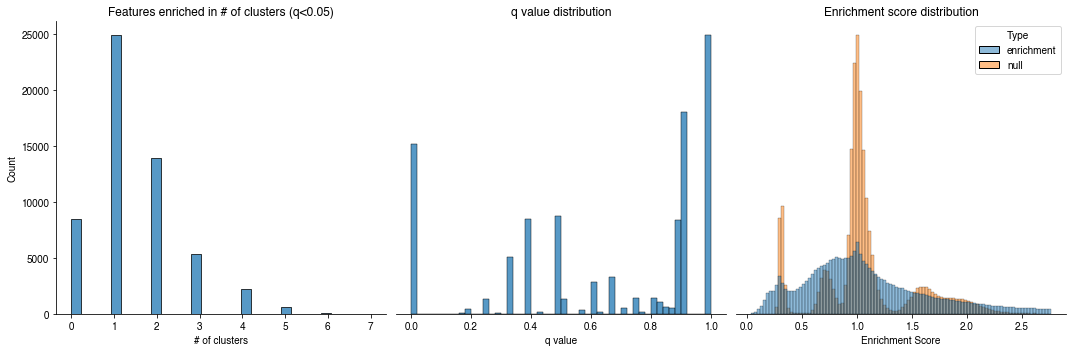

In [30]:
cluster_enriched_features(adata,
                          cluster_col='cluster',
                          top_n=200,
                          alpha=0.05,
                          stat_plot=True,
                          method='mc')

In [32]:
qvals = pd.DataFrame(
    adata.uns['cluster_feature_enrichment']['qvals'],
    index=adata.var_names,
    columns=adata.uns['cluster_feature_enrichment']
    ['cluster_order'])

qvals.to_hdf('mCH.cluster_enrichment_qvals.hdf', key='data')